# Přísnost známkování na PISA 2018

Vzorek:
- omez PISA 18 pouze na 9. ročníky ZŠ (tzn. vyřaď i víceletá gymnázia a 7. a 8. ročníky)
- podívej se na přísnost v různých předmětech (asi hlavně matematika, tam je nejspíš kurikulum nejvíce podobné)

Metodologie:
- přísnost na úrovni škol
  1. přísnost jako průměrné reziduum?
  2. přísnost jako fixed effect?
  3. můžu udělat nějakou simulaci na random effect model
- jak to půjde zkombinovat s váhami a plausible values?


## Načtení dat

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [3]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [4]:
sch18_vars = sch18[['CNTSCHID', 'SC013Q01TA', 'SCHSIZE']].copy()
sch18_vars['sch_public'] = np.where(sch18_vars['SC013Q01TA'].isnull(), pd.NA, sch18_vars['SC013Q01TA'] == 1)
sch18_vars['sch_pupils'] = sch18_vars['SCHSIZE']
sch18_vars = sch18_vars.drop(columns=['SC013Q01TA', 'SCHSIZE'])

## Příprava dat

Známky jsou ve sloupcích:
- ST800C01HA_CZ -- ST800C07HA_CZ
- odpovědi jsou 1-6, kde 6 = Předmět nemáme, jinak je to přímo známka
- předměty:
    - 01 = Matematika
    - 02 = Český jazyk
    - 03 = Cizí jazyk
    - 04 = Fyzika
    - 05 = Chemie
    - 06 = Přírodopis / biologie
    - 07 = Zeměpis


In [13]:
# kodovani od Radka Blazka pro PISA 2015 - sedi to i na 2018? -- ano, zjevne to sedi
strat_id = {
    1 : 'PHA',
    2 : 'STC',
    3 : 'PLK',
    4 : 'KVK',
    5 : 'ULK',
    6 : 'JHC',
    7 : 'LBK',
    8 : 'HKK',
    9 : 'PAK',
    10 : 'VYS',
    11 : 'JHM',
    12 : 'OLK',
    13 : 'MSK',
    14 : 'ZLK'
}

In [6]:
col_math = [f'PV{i}MATH' for i in range(1,11)]
col_read = [f'PV{i}READ' for i in range(1,11)]
col_scie = [f'PV{i}SCIE' for i in range(1,11)]
col_w = 'W_FSTUWT'
col_str = 'STRATUM'
col_sch = 'CNTSCHID'
col_gg = 'ST001D01T'
col_gr = [f'ST800C0{i}HA_CZ' for i in range(1, 8)]
col_escs = 'ESCS'
col_sex = 'ST004D01T'
col_all = [col_sch, col_str, col_w, col_gg, col_escs, col_sex] + col_math + col_read + col_scie + col_gr

In [7]:
df18 = stu18[col_all].copy()

In [8]:
df18 = pd.merge(df18, sch18_vars)

In [9]:
df18['stratum_label'] = df18['STRATUM'].apply(lambda x: stu18_meta.variable_value_labels['STRATUM'][x])

In [10]:
df18['sch_type'] = \
    np.where(df18['stratum_label'].str.contains('Basic'), 'zs',
        np.where(df18['stratum_label'].str.contains('6-8yrGym'), 'gym',
            np.where(df18['stratum_label'].str.contains('4yr Gym'), 'gym4',
                np.where(df18['stratum_label'].str.contains('Voc-Tech-Conservatory with maturate'), 'sos',
                    np.where(df18['stratum_label'].str.contains('Voc-Tech Secondary without maturate'), 'sou',
                        np.where(df18['stratum_label'].str.contains('Special & practical'), 'spec', 'undisclosed'))))))

In [14]:
def parse_region(x):
    res = re.search('Region([0-9]+)$', x)
    if res is not None:
        return int(res.group(1))
    else:
        return 0
df18['reg_id'] = df18['stratum_label'].apply(parse_region)
df18['reg'] = df18['reg_id'].apply(lambda x: strat_id[x] if x else None)

In [15]:
df18['math'] = df18[col_math].mean(axis=1)
df18['read'] = df18[col_read].mean(axis=1)
df18['scie'] = df18[col_scie].mean(axis=1)
df18['w'] = df18[col_w]
df18['sch_id'] = df18[col_sch]
df18['gr'] = df18[col_gg]
df18['girl'] = df18[col_sex] == 1
df18['escs'] = df18['ESCS']

In [16]:
df18['sch_size'] = pd.cut(df18['sch_pupils'], [0, 250, 400, 550, np.inf])

In [17]:
col_start = ['sch_id', 'sch_type', 'sch_public', 'sch_size', 'reg_id', 'reg', 'gr', 'girl', 'w', 'math', 'read', 'scie', 'stratum_label', 'escs']
df18 = df18[col_start + col_all].copy()

In [18]:
df18.shape

(7019, 57)

In [19]:
df18 = df18[(df18['gr'] == 9) & (df18['sch_type'] == 'zs')].copy()

In [20]:
df18.shape

(2187, 57)

In [22]:
df18.head()

,sch_id,sch_type,sch_public,sch_size,reg_id,reg,gr,girl,w,math,...,PV8SCIE,PV9SCIE,PV10SCIE,ST800C01HA_CZ,ST800C02HA_CZ,ST800C03HA_CZ,ST800C04HA_CZ,ST800C05HA_CZ,ST800C06HA_CZ,ST800C07HA_CZ
53,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,383.7898,...,479.315,412.525,451.004,2.0,3.0,3.0,2.0,2.0,2.0,1.0
54,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,505.2687,...,506.603,486.490,513.067,2.0,3.0,1.0,2.0,3.0,4.0,3.0
55,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,537.5343,...,480.488,511.705,546.012,1.0,2.0,1.0,1.0,1.0,1.0,1.0
56,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,True,23.75319,433.9740,...,439.402,373.254,391.580,5.0,2.0,2.0,2.0,2.0,2.0,2.0
57,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,456.2012,...,390.964,445.031,450.410,2.0,2.0,3.0,2.0,3.0,3.0,2.0


## Známky

Poskládej nějaké modely.

In [24]:
# fix missing grades
for c in col_gr:
    df18[c] = df18[c].replace(6, np.nan)

In [25]:
subjects = ['matematika', 'ceskyjazyk', 'cizijazyk', 'fyzika', 'chemie', 'prirodopis', 'zemepis']
for i in range(7):
    df18[f'gr_{subjects[i]}'] = df18[f'ST800C0{i+1}HA_CZ']

### Model 1: Skór ~ známka

In [26]:
reg_math = smf.wls('math ~ gr_matematika', df18[['math', 'gr_matematika']], weights=df18['w']).fit()
reg_math.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   math   R-squared:                       0.229
Model:                            WLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     558.4
Date:                Thu, 24 Mar 2022   Prob (F-statistic):          2.63e-108
Time:                        10:48:49   Log-Likelihood:                -10588.
No. Observations:                1881   AIC:                         2.118e+04
Df Residuals:                    1879   BIC:                         2.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       551.4250      3.447    159.977      0.000     544.665     558.185
gr_matematika   -23.2638      0.984    -23.631      0.000     -25.195     -21.333
==============================================================================
Omnibus:                       20.029   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.076
Skew:                          -0.172   Prob(JB):                     5.92e-06
Kurtosis:                       3.434   Cond. No.                         8.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
df18['pred_math'] = reg_math.predict(df18)
df18['resid_math'] = df18['math'] - df18['pred_math']

In [88]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [94]:
%time
# ok, výsledky na krajích jsou stejné jako předtím
res = df18.groupby(['reg'], dropna=False)[['resid_math', 'math', 'w']].apply(nanaverage, weights='w').reset_index()
res

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


,reg,resid_math,math
0,HKK,-13.293154,461.116016
1,JHC,5.809357,484.291486
2,JHM,-5.419375,473.936857
3,KVK,-0.317318,464.762466
4,LBK,5.380891,485.712619
5,MSK,-8.317895,470.524797
6,OLK,-6.295504,475.332087
7,PAK,8.256270,481.056228
8,PHA,9.197187,487.922531
9,PLK,15.028436,484.872376


In [96]:
res = df18.groupby(['sch_id'], dropna=False)[['resid_math', 'math', 'w']].apply(nanaverage, weights='w').reset_index()

In [97]:
res

,sch_id,resid_math,math
0,20300002.0,-11.302226,467.356408
1,20300005.0,-5.984425,474.217628
2,20300006.0,-33.249437,447.629489
3,20300010.0,5.422670,480.636263
4,20300018.0,5.731685,485.055448
...,...,...,...
124,20300322.0,-76.309761,411.821932
125,20300323.0,17.055159,497.046720
126,20300326.0,-13.247515,476.289971
127,20300329.0,19.216613,513.263535


<AxesSubplot:xlabel='math', ylabel='resid_math'>

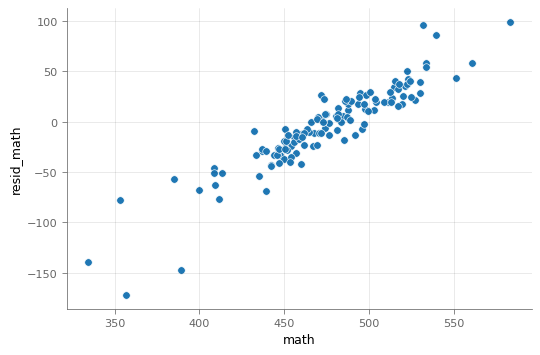

In [98]:
sns.scatterplot(data=res, x='math', y='resid_math')

### Is this meaningful?
- It should be like this even in case of random deviations, right?
- Try some simulation on it.

## Just noise model

In [141]:
n = 10_000
nsch = 100
a = 575
b = -25
sim1 = pd.DataFrame()
#sim['math'] = np.random.normal(loc=500, scale=100, size=n)
sim1['grade'] = np.random.randint(5, size=n) + 1
sim1['epsilon'] = np.random.normal(loc=0, scale=100, size=n)
sim1['schid'] = np.random.randint(nsch, size=n)
sim1['stid'] = sim1.index
sim1['score'] = a + b * sim1['grade'] + sim1['epsilon']

In [120]:
sres1 = sim1.groupby(['schid'], dropna=False)[['epsilon', 'score']].apply(nanaverage).reset_index()

<AxesSubplot:xlabel='score', ylabel='epsilon'>

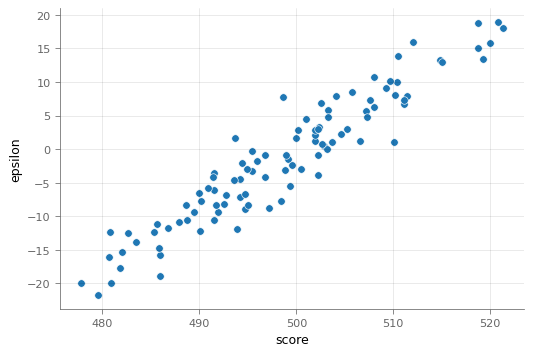

In [121]:
sns.scatterplot(data=sres1, x='score', y='epsilon')

**Yeah, so this model is rubbish!**

Can I describe it in terms of stats?

## School effect

In [142]:
n = 10_000
nsch = 100
a = 575
b = -25

sim2sch = pd.DataFrame()
sim2sch['schid'] = np.arange(nsch)
sim2sch['mu'] = np.random.normal(loc=0, scale=50, size=nsch)

sim2 = pd.DataFrame()
#sim['math'] = np.random.normal(loc=500, scale=100, size=n)
sim2['grade'] = np.random.randint(5, size=n) + 1
sim2['epsilon'] = np.random.normal(loc=0, scale=100, size=n)
sim2['schid'] = np.random.randint(nsch, size=n)
sim2 = pd.merge(sim2, sim2sch)
sim2['stid'] = sim2.index
sim2['score'] = a + b * sim2['grade'] + sim2['epsilon'] + sim2['mu']
sim2['epsilonmu'] = sim2['epsilon'] + sim2['mu']

In [125]:
sres2 = sim2.groupby(['schid'], dropna=False)[['epsilonmu', 'score']].apply(nanaverage).reset_index()

<AxesSubplot:xlabel='score', ylabel='epsilonmu'>

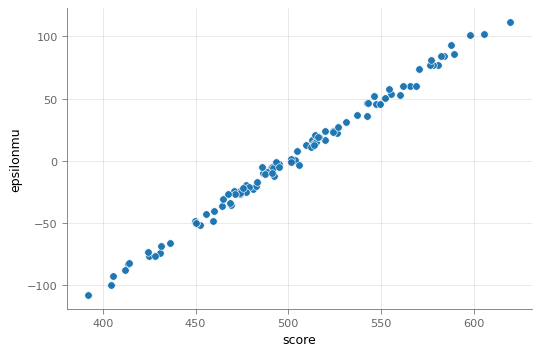

In [127]:
sns.scatterplot(data=sres2, x='score', y='epsilonmu')

In [129]:
pd.get_dummies(sim2['schid'])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Plain OLS and F-test

This is equivalent to FE model.

In [175]:
X1r = np.hstack([np.ones(n)[:, np.newaxis], sim1[['grade']]])

In [176]:
X1 = np.hstack([X1r, pd.get_dummies(sim1['schid'])])

In [183]:
y1 = sim1['score'].values[:, np.newaxis]

In [184]:
y1

array([[448.88340838],
       [543.65273576],
       [503.67246175],
       ...,
       [483.40108602],
       [445.88295217],
       [325.6533006 ]])

In [189]:
XX1r_inv = np.linalg.inv(X1r.T @ X1r)

In [190]:
XX1_inv = np.linalg.inv(X1.T @ X1)

In [193]:
b1r = XX1r_inv @ X1r.T @ y1

In [194]:
b1r

array([[571.06268206],
       [-23.46561911]])

In [255]:
res1r = smf.ols('score ~ grade', data=sim1).fit()

In [256]:
res1r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1111.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          4.88e-231
Time:                        18:02:17   Log-Likelihood:                -60160.
No. Observations:               10000   AIC:                         1.203e+05
Df Residuals:                    9998   BIC:                         1.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    571.0627      2.328    245.259      0.000     566.499     575.627
grade        -23.4656      0.704    -33.328      0.000     -24.846     -22.085
==============================================================================
Omnibus:                        1.849   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                1.880
Skew:                          -0.029   Prob(JB):                        0.391
Kurtosis:                       2.967   Cond. No.                         8.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
' + '.join([str(i) for i in range(100)])

'0 + 1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9 + 10 + 11 + 12 + 13 + 14 + 15 + 16 + 17 + 18 + 19 + 20 + 21 + 22 + 23 + 24 + 25 + 26 + 27 + 28 + 29 + 30 + 31 + 32 + 33 + 34 + 35 + 36 + 37 + 38 + 39 + 40 + 41 + 42 + 43 + 44 + 45 + 46 + 47 + 48 + 49 + 50 + 51 + 52 + 53 + 54 + 55 + 56 + 57 + 58 + 59 + 60 + 61 + 62 + 63 + 64 + 65 + 66 + 67 + 68 + 69 + 70 + 71 + 72 + 73 + 74 + 75 + 76 + 77 + 78 + 79 + 80 + 81 + 82 + 83 + 84 + 85 + 86 + 87 + 88 + 89 + 90 + 91 + 92 + 93 + 94 + 95 + 96 + 97 + 98 + 99'

In [225]:
dummies = pd.get_dummies(sim1['schid'], prefix='d')

In [226]:
foo = pd.concat([sim1, dummies], axis=1)


In [222]:
foo.columns

Index(['grade', 'epsilon', 'schid', 'stid', 'score', 'd_0', 'd_1', 'd_2',
       'd_3', 'd_4',
       ...
       'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98',
       'd_99'],
      dtype='object', length=105)

In [210]:
' + '.join(['a', 'b'])

'a + b'

In [253]:
dummies = pd.get_dummies(sim1['schid'], prefix='d')
foo = pd.concat([sim1, dummies], axis=1)
frm = 'score ~ grade + ' + ' + '.join(dummies.columns)
res1 = smf.ols(frm, data=foo).fit()

In [295]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     12.23
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          9.19e-180
Time:                        19:42:53   Log-Likelihood:                -60105.
No. Observations:               10000   AIC:                         1.204e+05
Df Residuals:                    9899   BIC:                         1.211e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    564.8884      2.319    243.541      0.000     560.342     569.435
grade        -23.3153      0.708    -32.917      0.000     -24.704     -21.927
d_0            8.4522      9.585      0.882      0.378     -10.337      27.242
d_1            0.6602     10.016      0.066      0.947     -18.972      20.293
d_2           -3.3945     10.337     -0.328      0.743     -23.658      16.869
d_3           10.5026      9.585      1.096      0.273      -8.286      29.292
d_4           -4.5801     10.227     -0.448      0.654     -24.626      15.466
d_5          -15.7462     10.015     -1.572      0.116     -35.378       3.886
d_6            4.8996      9.369      0.523      0.601     -13.466      23.265
d_7            0.8781     10.281      0.085      0.932     -19.276      21.032
d_8          -12.3030     10.283     -1.196      0.232     -32.460       7.853
d_9            6.3904      9.722      0.657      0.511     -12.667      25.448
d_10           2.2903     10.016      0.229      0.819     -17.343      21.923
d_11           2.8978     10.120      0.286      0.775     -16.939      22.734
d_12          -5.8439      9.676     -0.604      0.546     -24.811      13.124
d_13           2.5508      9.769      0.261      0.794     -16.599      21.701
d_14          -4.1918      9.769     -0.429      0.668     -23.342      14.958
d_15          15.1676      9.630      1.575      0.115      -3.710      34.045
d_16           4.8201     10.228      0.471      0.637     -15.228      24.869
d_17          -1.9333      9.497     -0.204      0.839     -20.550      16.683
d_18          16.0708     11.158      1.440      0.150      -5.802      37.943
d_19          10.0547      9.872      1.019      0.308      -9.296      29.405
d_20           1.6460      9.866      0.167      0.867     -17.693      20.984
d_21          -5.0030     10.571     -0.473      0.636     -25.725      15.719
d_22          -8.5625      9.630     -0.889      0.374     -27.440      10.315
d_23          29.7769      9.411      3.164      0.002      11.329      48.225
d_24          -0.4755      9.586     -0.050      0.960     -19.267      18.316
d_25           5.1360     10.015      0.513      0.608     -14.496      24.768
d_26          20.4456      9.585      2.133      0.033       1.657      39.235
d_27           1.6495      8.837      0.187      0.852     -15.672      18.971
d_28          18.4159     10.452      1.762      0.078      -2.072      38.903
d_29           6.9914      9.411      0.743      0.458     -11.456      25.439
d_30           3.9319      9.370      0.420      0.675     -14.436      22.299
d_31          -2.4917     10.821     -0.230      0.818     -23.704      18.720
d_32           5.7196      9.676      0.591      0.554     -13.247      24.687
d_33           9.5969     10.452      0.918      0.359     -10.892      30.086
d_

In [246]:
nsch

100

In [258]:
# this should by my F value
((res1r.ssr - res1.ssr) / nsch) / (res1.ssr / (n - 2))

1.1228418522700796

In [249]:
import scipy.stats

In [251]:
# and corresponding critical value for 95% F:
scipy.stats.f.ppf(q=1 - 0.05, dfn=nsch, dfd=n - 2)

1.2450568194711773

In [259]:
res2r = smf.ols('score ~ grade', data=sim2).fit()

In [260]:
res2r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     990.0
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          2.68e-207
Time:                        18:03:24   Log-Likelihood:                -61346.
No. Observations:               10000   AIC:                         1.227e+05
Df Residuals:                    9998   BIC:                         1.227e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    575.5940      2.636    218.326      0.000     570.426     580.762
grade        -24.9358      0.792    -31.465      0.000     -26.489     -23.382
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.538
Skew:                          -0.029   Prob(JB):                        0.463
Kurtosis:                       2.981   Cond. No.                         8.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
dummies = pd.get_dummies(sim2['schid'], prefix='d')
foo = pd.concat([sim2, dummies], axis=1)
frm = 'score ~ grade + ' + ' + '.join(dummies.columns)
res2 = smf.ols(frm, data=foo).fit()

In [284]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     36.55
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:22   Log-Likelihood:                -60247.
No. Observations:               10000   AIC:                         1.207e+05
Df Residuals:                    9899   BIC:                         1.214e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    568.8045      2.358    241.183      0.000     564.182     573.427
grade        -24.7173      0.716    -34.503      0.000     -26.122     -23.313
d_0           -7.6894      9.814     -0.783      0.433     -26.927      11.549
d_1          -22.2841      9.677     -2.303      0.021     -41.253      -3.315
d_2          -95.7138     10.318     -9.276      0.000    -115.939     -75.488
d_3           19.2767      9.768      1.973      0.048       0.129      38.424
d_4           48.3054     10.910      4.428      0.000      26.919      69.691
d_5         -139.8399      9.633    -14.517      0.000    -158.722    -120.958
d_6          -34.8452     11.247     -3.098      0.002     -56.891     -12.800
d_7           64.5761      9.768      6.611      0.000      45.428      83.724
d_8           16.2955     10.211      1.596      0.111      -3.720      36.311
d_9          -52.0569     10.846     -4.800      0.000     -73.317     -30.797
d_10          12.7048      9.462      1.343      0.179      -5.843      31.252
d_11          37.5829      9.546      3.937      0.000      18.870      56.296
d_12         -15.0626      9.633     -1.564      0.118     -33.945       3.820
d_13          28.8141     10.602      2.718      0.007       8.032      49.597
d_14          19.3322     10.057      1.922      0.055      -0.381      39.045
d_15          64.0120      9.339      6.854      0.000      45.706      82.318
d_16         -22.3149      9.722     -2.295      0.022     -41.373      -3.257
d_17         -52.2514      9.957     -5.247      0.000     -71.770     -32.733
d_18          -7.2918      9.678     -0.753      0.451     -26.262      11.678
d_19         115.7173      9.546     12.122      0.000      97.005     134.430
d_20          87.1959     10.057      8.671      0.000      67.483     106.909
d_21          48.4150     10.485      4.617      0.000      27.862      68.968
d_22          28.9786     10.107      2.867      0.004       9.166      48.791
d_23          86.1841      9.909      8.697      0.000      66.760     105.609
d_24         109.7448     10.318     10.636      0.000      89.519     129.971
d_25           5.1670     10.485      0.493      0.622     -15.386      25.720
d_26          27.4454      9.816      2.796      0.005       8.203      46.688
d_27          -9.4428     10.485     -0.901      0.368     -29.996      11.110
d_28         -19.9397     10.429     -1.912      0.056     -40.383       0.504
d_29         -78.5590     10.108     -7.772      0.000     -98.372     -58.746
d_30         -20.8077     10.108     -2.059      0.040     -40.621      -0.994
d_31          -0.5594      9.814     -0.057      0.955     -19.798      18.679
d_32          25.3655      9.107      2.785      0.005       7.514      43.216
d_33         -56.4284     10.057     -5.611      0.000     -76.141     -36.715
d_

In [292]:
B = np.hstack([np.zeros([nsch, 2]), np.eye(nsch)])

In [293]:
res2.f_test(B)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=612.3269902946523, p=0.0, df_denom=9.9e+03, df_num=100>

In [294]:
res1.f_test(B)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=603.3637305178817, p=0.0, df_denom=9.9e+03, df_num=100>

In [285]:
res2.f_test()

<bound method LikelihoodModelResults.f_test of <statsmodels.regression.linear_model.OLSResults object at 0x7fef5e8a8e20>>

In [263]:
# this should by my F value
((res2r.ssr - res2.ssr) / nsch) / (res2.ssr / (n - 2))

24.58359662993956

In [264]:
# and corresponding critical value for 95% F:
scipy.stats.f.ppf(q=1 - 0.05, dfn=nsch, dfd=n - 2)

1.2450568194711773

In [270]:
res2.params[2:].mean()

5.688044504676411

In [273]:
res2.params[2:].std()

49.971609126472046

In [274]:
res1.params[2:].std()

10.759973434066248

In [241]:
np.sum((sim1['score'] - res1.predict(sim1)) ** 2)

98400595.20961183

In [244]:
np.average((sim1['score'] - res1.predict(sim1)) ** 2) * 10000 / 9998

9842.027926546492

In [232]:
res1._results.__dict__

{'params': array([571.06268206, -23.46561911]),
 'model': <statsmodels.regression.linear_model.OLS at 0x7fef5fd37e80>,
 'k_constant': 1,
 '_data_attr': [],
 '_data_in_cache': ['fittedvalues', 'resid', 'wresid'],
 'normalized_cov_params': array([[ 5.50849723e-04, -1.50695141e-04],
        [-1.50695141e-04,  5.03693900e-05]]),
 '_use_t': True,
 '_cache': {'wresid': array([ -28.31679723,   -3.94432719,  -20.45898209, ...,  -17.26473871,
          -78.24849166, -151.54690501]),
  'eigenvals': array([117674.86592563,   1687.13407437]),
  'condition_number': 8.351549464398133,
  'ssr': 98400595.20961182,
  'centered_tss': 109332537.8187699,
  'rsquared': 0.09998800747933723,
  'nobs': 10000.0,
  'rsquared_adj': 0.09989798827624441,
  'ess': 10931942.609158084,
  'mse_model': 10931942.609158084,
  'mse_resid': 9842.02792654649,
  'fvalue': 1110.7408646618255,
  'f_pvalue': 4.8847491317785626e-231,
  'llf': -60160.4705265776,
  'aic': 120324.9410531552,
  'bic': 120339.36173389915,
  'scale': 

In [234]:
res2._results.__dict__

{'params': array([ 5.64888402e+02, -2.33152652e+01,  8.45223811e+00,  6.60214853e-01,
        -3.39451587e+00,  1.05025670e+01, -4.58005909e+00, -1.57461520e+01,
         4.89960589e+00,  8.78127784e-01, -1.23030450e+01,  6.39040150e+00,
         2.29025741e+00,  2.89777133e+00, -5.84394991e+00,  2.55077700e+00,
        -4.19180880e+00,  1.51676417e+01,  4.82010212e+00, -1.93330888e+00,
         1.60708187e+01,  1.00547090e+01,  1.64596621e+00, -5.00299468e+00,
        -8.56254415e+00,  2.97769370e+01, -4.75466297e-01,  5.13596993e+00,
         2.04456332e+01,  1.64946498e+00,  1.84158944e+01,  6.99138006e+00,
         3.93187402e+00, -2.49174648e+00,  5.71963448e+00,  9.59688085e+00,
         2.35223479e+00,  1.57566212e+01,  6.17409605e+00, -2.48215111e+00,
        -5.35509066e-01, -6.06774926e+00,  1.19264708e+01,  1.21309499e+01,
         3.19272072e+01,  2.91017540e+01, -1.14538695e+01,  1.50623579e+01,
        -1.08095011e+01,  1.66240818e+00,  5.14461458e+00,  8.98809870e+00,
  

In [195]:
b1 = XX1_inv @ X1.T @ y1

In [197]:
XX1_inv

array([[-5.41298032e+12, -9.32083673e-04,  5.41298032e+12, ...,
         5.41298032e+12,  5.41298032e+12,  5.41298032e+12],
       [ 5.30376258e-04,  5.10383395e-05, -6.86369275e-04, ...,
        -6.95787721e-04, -6.80482746e-04, -6.76950828e-04],
       [ 5.41298032e+12,  7.85709567e-04, -5.41298032e+12, ...,
        -5.41298032e+12, -5.41298032e+12, -5.41298032e+12],
       ...,
       [ 5.41298032e+12,  7.69835478e-04, -5.41298032e+12, ...,
        -5.41298032e+12, -5.41298032e+12, -5.41298032e+12],
       [ 5.41298032e+12,  7.81572652e-04, -5.41298032e+12, ...,
        -5.41298032e+12, -5.41298032e+12, -5.41298032e+12],
       [ 5.41298032e+12,  7.83406771e-04, -5.41298032e+12, ...,
        -5.41298032e+12, -5.41298032e+12, -5.41298032e+12]])

In [196]:
b1

array([[-9.87774834e+03],
       [-5.78171501e+01],
       [-7.58521678e+03],
       [ 1.48568348e+03],
       [ 6.46185619e+03],
       [-3.51535339e+03],
       [ 5.36581157e+03],
       [ 1.05722538e+04],
       [ 7.65537865e+03],
       [-1.14609979e+03],
       [ 4.71625518e+02],
       [ 6.54996807e+03],
       [ 3.47305790e+03],
       [ 8.09510575e+03],
       [ 1.64046238e+03],
       [ 5.16743065e+02],
       [ 6.62059735e+03],
       [ 7.82411901e+03],
       [ 1.20747568e+04],
       [-6.97233281e+03],
       [-5.35700008e+03],
       [ 5.68544932e+03],
       [ 1.06793371e+03],
       [ 8.75011725e+03],
       [ 3.31981227e+03],
       [ 1.21690757e+04],
       [ 2.33582543e+03],
       [ 4.26173474e+03],
       [ 2.38960634e+03],
       [-3.53513499e+02],
       [ 6.31216786e+03],
       [ 5.70603974e+03],
       [ 5.11775388e+03],
       [ 4.12107714e+03],
       [ 7.56101751e+03],
       [-2.02959943e+03],
       [ 1.25444608e+03],
       [ 6.84554445e+03],
       [ 4.5

In [178]:
X1

array([[1., 4., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       ...,
       [1., 3., 0., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [1., 4., 0., ..., 0., 0., 0.]])

In [160]:
sim1[['grade']]

,grade
0,4
1,1
2,2
3,2
4,3
...,...
9995,5
9996,2
9997,3
9998,2


In [111]:
np.random.randint(10)

4

In [135]:
!pip install linearmodels

     |████████████████████████████████| 1.5 MB 3.0 MB/s eta 0:00:01     |██████████████                  | 655 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 3.9 MB/s eta 0:00:01
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
     |████████████████████████████████| 77 kB 2.1 MB/s eta 0:00:011


In [137]:
from linearmodels.panel import PanelOLS

In [138]:
foo.head()

grade     epsilon         mu       score   epsilonmu
schid stid                                                      
19    0         3   29.913236 -58.155085  471.758151  -28.241849
      1         4  106.623897 -58.155085  523.468812   48.468812
      2         3   -0.769013 -58.155085  441.075902  -58.924098
      3         2  161.130907 -58.155085  627.975822  102.975822
      4         2  -32.129539 -58.155085  434.715376  -90.284624

In [302]:
res1r.llf

-60160.4705265776

In [143]:
foo = sim2.set_index(['schid', 'stid'])
mod = PanelOLS(foo['score'], foo['grade'], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  score   R-squared:                        0.1074
Estimator:                   PanelOLS   R-squared (Between):             -0.3166
No. Observations:               10000   R-squared (Within):               0.1074
Date:                Sun, Mar 27 2022   R-squared (Overall):             -0.2985
Time:                        13:44:38   Log-likelihood                -6.025e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1190.5
Entities:                         100   P-value                           0.0000
Avg Obs:                      100.000   Distribution:                  F(1,9899)
Min Obs:                       79.000                                           
Max Obs:                       121.00   F-statistic (robust):             1601.3
                            

In [144]:
foo = sim1.set_index(['schid', 'stid'])
mod = PanelOLS(foo['score'], foo['grade'], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  score   R-squared:                        0.0987
Estimator:                   PanelOLS   R-squared (Between):             -0.2978
No. Observations:               10000   R-squared (Within):               0.0987
Date:                Sun, Mar 27 2022   R-squared (Overall):             -0.2813
Time:                        13:44:46   Log-likelihood                 -6.01e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1083.5
Entities:                         100   P-value                           0.0000
Avg Obs:                      100.000   Distribution:                  F(1,9899)
Min Obs:                       78.000                                           
Max Obs:                       132.00   F-statistic (robust):             1309.6
                            

In [145]:
import statsmodels.formula.api as smf

In [303]:
md2 = smf.mixedlm('score ~ grade', sim2, groups=sim2['schid'])
mdf2 = md2.fit()
mdf2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: score      
No. Observations: 10000   Method:             REML       
No. Groups:       100     Scale:              10113.6222 
Min. group size:  79      Log-Likelihood:     -60453.5707
Max. group size:  121     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  574.539    5.442 105.569 0.000 563.872 585.206
grade      -24.726    0.716 -34.521 0.000 -26.130 -23.322
Group Var 2394.640    3.546                              
=========================================================

"""

In [304]:
md1 = smf.mixedlm('score ~ grade', sim1, groups=sim1['schid'])
mdf1 = md1.fit()
mdf1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: score      
No. Observations: 10000   Method:             REML       
No. Groups:       100     Scale:              9833.5659  
Min. group size:  78      Log-Likelihood:     -60158.8276
Max. group size:  132     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  571.021    2.348 243.188 0.000 566.419 575.623
grade      -23.454    0.704 -33.294 0.000 -24.834 -22.073
Group Var    8.576    0.159                              
=========================================================

"""

In [305]:
res1r.llf, mdf1.llf

(-60160.4705265776, -60158.82763933359)

In [306]:
res2r.llf, mdf2.llf

(-61346.04550335173, -60453.57068972366)

In [313]:
2 * (mdf1.llf - res1r.llf)  # should be multiplied by two?

3.2857744880166138

In [314]:
scipy.stats.chi2.ppf(q=1 - 0.05, df=1) 

3.841458820694124

In [282]:
mdf1.params

Intercept    571.020722
grade        -23.453766
Group Var      0.000872
dtype: float64

Intercept    574.538810
grade        -24.725817
Group Var      0.236774
dtype: float64

In [376]:
df18.head()

,sch_id,sch_type,sch_public,sch_size,reg_id,reg,gr,girl,w,math,...,ST800C07HA_CZ,gr_matematika,gr_ceskyjazyk,gr_cizijazyk,gr_fyzika,gr_chemie,gr_prirodopis,gr_zemepis,pred_math,resid_math
53,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,383.7898,...,1.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0,504.897463,-121.107663
54,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,505.2687,...,3.0,2.0,3.0,1.0,2.0,3.0,4.0,3.0,504.897463,0.371237
55,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,537.5343,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,528.161256,9.373044
56,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,True,23.75319,433.9740,...,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,435.106086,-1.132086
57,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,456.2012,...,2.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,504.897463,-48.696263


In [375]:
foo = df18[['math', 'gr_matematika', 'sch_id']].reset_index().dropna()
mod = smf.mixedlm('math ~ gr_matematika', foo, groups=foo['sch_id'])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  math       
No. Observations:  1881     Method:              REML       
No. Groups:        128      Scale:               3444.4670  
Min. group size:   1        Log-Likelihood:      -10420.8844
Max. group size:   34       Converged:           Yes        
Mean group size:   14.7                                     
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     546.354    4.242 128.794 0.000 538.040 554.668
gr_matematika -22.427    0.911 -24.630 0.000 -24.212 -20.643
Group Var     929.744    2.868                              
============================================================

"""

In [ ]:
reg_math = smf.wls('math ~ gr_matematika', df18[['math', 'gr_matematika']], weights=df18['w']).fit()

In [156]:
df18[['math', 'gr_matematika', 'sch_id']].iloc[1995,:]

math             3.896626e+02
gr_matematika    4.000000e+00
sch_id           2.030002e+07
Name: 6656, dtype: float64

In [276]:
sim1.to_csv('temp/sim1.csv')
sim2.to_csv('temp/sim2.csv')

In [377]:
df18.shape

(2187, 66)

In [382]:
df18.drop(columns=['sch_size']).to_csv('temp/df18.csv', index=False)

In [278]:
!mkdir rlib

## Misc

### Masked arrays

In [45]:
x = np.random.normal(size=(10, 5))

In [46]:
x

array([[-0.43361634,  0.26602004, -2.53867835,  0.57887743, -0.1119374 ],
       [-0.39279568, -0.07861964,  0.2566515 ,  0.84739183,  0.75187825],
       [-0.56962417,  0.75375305, -1.80011002,  0.61290991,  1.03665117],
       [-0.90370539, -0.13149645, -1.59094729,  1.88228202, -0.95580254],
       [-0.34406312,  1.742105  , -0.41283192,  0.69431696, -1.49655741],
       [-0.19084989, -1.44501595,  1.12651847, -0.03658997, -0.52015467],
       [ 0.14695933,  0.54265122, -0.35990145,  0.51000146, -0.23402202],
       [ 1.0047015 , -0.13491847,  0.86918162,  0.03108247,  0.69250066],
       [ 0.15020456, -0.58649235,  0.76757716, -0.09235715, -1.71386499],
       [-0.19353057,  0.97352066, -1.56823971,  0.12377628, -0.62223394]])

In [47]:
mask = x < 0

In [52]:
np.nanmean(x, axis=1)

array([-0.44786692,  0.27690125,  0.00671599, -0.33993393,  0.0365939 ,
       -0.2132184 ,  0.12113771,  0.49250956, -0.29498655, -0.25734146])

In [48]:
mask

array([[ True, False,  True, False,  True],
       [ True,  True, False, False, False],
       [ True, False,  True, False, False],
       [ True,  True,  True, False,  True],
       [ True, False,  True, False,  True],
       [ True,  True, False,  True,  True],
       [False, False,  True, False,  True],
       [False,  True, False, False, False],
       [False,  True, False,  True,  True],
       [ True, False,  True, False,  True]])

In [49]:
xm = np.ma.masked_array(x, mask=mask)

In [38]:
xm.mean()

0.665426597132826

In [39]:
x.mean()

0.03219392673385402

In [42]:
np.sqrt(2 / np.pi)

0.7978845608028654

In [44]:
np.ma.average(xm, weights=xm)

0.8505486837329256

In [84]:
wm(df18['gr_matematika'])

3.1020733652312598

In [87]:
wm(df18[['gr_matematika', 'gr_ceskyjazyk', 'w']], weights='w')

gr_matematika    3.146832
gr_ceskyjazyk    2.381990
dtype: float64

In [81]:
isinstance(df18, pd.DataFrame)

True

In [82]:
5 if False else 4

4

In [315]:
stu18.columns

Index(['CNTSTUID', 'CNTSCHID', 'CNTRYID', 'STRATUM', 'STRATUMID_rec',
       'ST001D01T', 'ST003D02T', 'ST003D03T', 'ST004D01T', 'ST005Q01TA',
       ...
       'ST800C03HA_CZ', 'ST800C04HA_CZ', 'ST800C05HA_CZ', 'ST800C06HA_CZ',
       'ST800C07HA_CZ', 'ST801C01HA_CZ', 'ST802C01HA_CZ', 'ST802C02HA_CZ',
       'ST802C03HA_CZ', 'ST803C01HA_CZ'],
      dtype='object', length=724)

In [316]:
df18

,sch_id,sch_type,sch_public,sch_size,reg_id,reg,gr,girl,w,math,...,ST800C07HA_CZ,gr_matematika,gr_ceskyjazyk,gr_cizijazyk,gr_fyzika,gr_chemie,gr_prirodopis,gr_zemepis,pred_math,resid_math
53,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,383.7898,...,1.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0,504.897463,-121.107663
54,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,505.2687,...,3.0,2.0,3.0,1.0,2.0,3.0,4.0,3.0,504.897463,0.371237
55,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,537.5343,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,528.161256,9.373044
56,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,True,23.75319,433.9740,...,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,435.106086,-1.132086
57,20300080.0,zs,True,"(250.0, 400.0]",7,LBK,9.0,False,22.01021,456.2012,...,2.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,504.897463,-48.696263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,20300269.0,zs,True,"(0.0, 250.0]",2,STC,9.0,False,26.69619,375.2860,...,3.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,504.897463,-129.611463
7010,20300114.0,zs,True,"(0.0, 250.0]",13,MSK,9.0,True,26.09625,371.3937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7012,20300114.0,zs,True,"(0.0, 250.0]",13,MSK,9.0,True,26.09625,424.4324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7013,20300114.0,zs,True,"(0.0, 250.0]",13,MSK,9.0,True,26.09625,379.7803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Can I prepare data for R?

In [340]:
col_gr = [f'ST800C0{i}HA_CZ' for i in range(1, 8)]
col_gg = 'ST001D01T'
col_sex = 'ST004D01T'

cols = ['CNTSTUID', 'STRATUM', col_gg, col_sex] + col_gr

In [341]:
# kodovani od Radka Blazka pro PISA 2015 - sedi to i na 2018? -- ano, zjevne to sedi
strat_id = {
    1 : 'PHA',
    2 : 'STC',
    3 : 'PLK',
    4 : 'KVK',
    5 : 'ULK',
    6 : 'JHC',
    7 : 'LBK',
    8 : 'HKK',
    9 : 'PAK',
    10 : 'VYS',
    11 : 'JHM',
    12 : 'OLK',
    13 : 'MSK',
    14 : 'ZLK'
}

In [342]:
dfr18 = stu18[cols].copy()

In [343]:
dfr18['stratum_label'] = dfr18['STRATUM'].apply(lambda x: stu18_meta.variable_value_labels['STRATUM'][x])

In [344]:
dfr18['sch_type'] = \
    np.where(dfr18['stratum_label'].str.contains('Basic'), 'zs',
        np.where(dfr18['stratum_label'].str.contains('6-8yrGym'), 'gym',
            np.where(dfr18['stratum_label'].str.contains('4yr Gym'), 'gym4',
                np.where(dfr18['stratum_label'].str.contains('Voc-Tech-Conservatory with maturate'), 'sos',
                    np.where(dfr18['stratum_label'].str.contains('Voc-Tech Secondary without maturate'), 'sou',
                        np.where(dfr18['stratum_label'].str.contains('Special & practical'), 'spec', 'undisclosed'))))))

In [345]:
def parse_region(x):
    res = re.search('Region([0-9]+)$', x)
    if res is not None:
        return int(res.group(1))
    else:
        return 0
dfr18['reg_id'] = dfr18['stratum_label'].apply(parse_region)
dfr18['reg'] = dfr18['reg_id'].apply(lambda x: strat_id[x] if x else None)

In [346]:
dfr18.head()

,CNTSTUID,STRATUM,ST001D01T,ST004D01T,ST800C01HA_CZ,ST800C02HA_CZ,ST800C03HA_CZ,ST800C04HA_CZ,ST800C05HA_CZ,ST800C06HA_CZ,ST800C07HA_CZ,stratum_label,sch_type,reg_id,reg
0,20300001.0,CZE3030,10.0,2.0,4.0,3.0,1.0,3.0,4.0,6.0,6.0,CZE - stratum 30: Voc-Tech-Conservatory with m...,sos,0,None
1,20300002.0,CZE3131,10.0,2.0,5.0,2.0,2.0,3.0,3.0,6.0,6.0,CZE - stratum 31: Voc-Tech Secondary without m...,sou,0,None
2,20300003.0,CZE2929,10.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,CZE - stratum 29: 4yr Gym,gym4,0,None
3,20300004.0,CZE0707,9.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0,CZE - stratum 07: Basic/Region7,zs,7,LBK
4,20300005.0,CZE2424,9.0,2.0,5.0,3.0,2.0,1.0,3.0,2.0,2.0,CZE - stratum 24: 6-8yrGym/Region10,gym,10,VYS


In [363]:
dfr18['gr'] = dfr18[col_gg]
dfr18['girl'] = dfr18[col_sex] == 1
dfr18['to_keep'] = (dfr18['gr'] == 9) & (dfr18['sch_type'] == 'zs')
dfr18 = dfr18.rename(columns={'CNTSTUID': 'cntstuid'})
dfr18['cntstuid'] = np.int_(dfr18['cntstuid'])

In [355]:
# fix missing grades
for c in col_gr:
    dfr18[c] = dfr18[c].replace(6, np.nan)

In [356]:
subjects = ['matematika', 'ceskyjazyk', 'cizijazyk', 'fyzika', 'chemie', 'prirodopis', 'zemepis']
for i in range(7):
    dfr18[f'gr_{subjects[i]}'] = dfr18[f'ST800C0{i+1}HA_CZ']

In [353]:
ocol_gr = [f'gr_{x}' for x in subjects]
ocols = ['cntstuid', 'to_keep', 'gr', 'girl', 'sch_type', 'reg'] + ocol_gr

In [364]:
dfr18[ocols].head()

,cntstuid,to_keep,gr,girl,sch_type,reg,gr_matematika,gr_ceskyjazyk,gr_cizijazyk,gr_fyzika,gr_chemie,gr_prirodopis,gr_zemepis
0,20300001,False,10.0,False,sos,None,4.0,3.0,1.0,3.0,4.0,NaN,NaN
1,20300002,False,10.0,False,sou,None,5.0,2.0,2.0,3.0,3.0,NaN,NaN
2,20300003,False,10.0,False,gym4,None,2.0,1.0,2.0,1.0,2.0,1.0,1.0
3,20300004,True,9.0,False,zs,LBK,2.0,3.0,3.0,2.0,2.0,2.0,1.0
4,20300005,False,9.0,False,gym,VYS,5.0,3.0,2.0,1.0,3.0,2.0,2.0


In [366]:
dfr18[ocols].to_csv('temp/pisa18_r.csv', index=False)

In [386]:
foo = dfr18[dfr18['to_keep']]

In [387]:
foo['gr_matematika']

3       2.0
10      1.0
12      5.0
14      4.0
17      4.0
       ... 
7005    NaN
7006    2.0
7009    1.0
7017    1.0
7018    4.0
Name: gr_matematika, Length: 2187, dtype: float64

In [390]:
foo = foo[~foo['gr_matematika'].isnull()]

In [391]:
foo

,cntstuid,STRATUM,ST001D01T,ST004D01T,ST800C01HA_CZ,ST800C02HA_CZ,ST800C03HA_CZ,ST800C04HA_CZ,ST800C05HA_CZ,ST800C06HA_CZ,...,gr,girl,to_keep,gr_matematika,gr_ceskyjazyk,gr_cizijazyk,gr_fyzika,gr_chemie,gr_prirodopis,gr_zemepis
3,20300004,CZE0707,9.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,...,9.0,False,True,2.0,3.0,3.0,2.0,2.0,2.0,1.0
10,20300011,CZE1313,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9.0,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12,20300014,CZE0202,9.0,2.0,5.0,3.0,3.0,2.0,3.0,3.0,...,9.0,False,True,5.0,3.0,3.0,2.0,3.0,3.0,1.0
14,20300016,CZE1313,9.0,2.0,4.0,4.0,3.0,4.0,2.0,3.0,...,9.0,False,True,4.0,4.0,3.0,4.0,2.0,3.0,4.0
17,20300020,CZE0505,9.0,2.0,4.0,2.0,3.0,NaN,2.0,3.0,...,9.0,False,True,4.0,2.0,3.0,NaN,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7001,20307773,CZE0707,9.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,...,9.0,True,True,2.0,2.0,1.0,1.0,2.0,1.0,1.0
7006,20307778,CZE0202,9.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,...,9.0,True,True,2.0,2.0,1.0,2.0,2.0,1.0,2.0
7009,20307781,CZE0606,9.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,9.0,True,True,1.0,2.0,1.0,1.0,1.0,1.0,1.0
7017,20307790,CZE0707,9.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9.0,False,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [392]:
foo.cntschid

AttributeError: 'DataFrame' object has no attribute 'cntschid'

In [367]:
sch18.head()

,CNTRYID,CNTSCHID,SC001Q01TA,SC013Q01TA,SC016Q01TA,SC016Q02TA,SC016Q03TA,SC016Q04TA,SC017Q01NA,SC017Q02NA,...,CLSIZE,CREACTIV,EDUSHORT,STAFFSHORT,STUBEHA,TEACHBEHA,W_SCHGRNRABWT,W_FSTUWT_SCH_SUM,SENWT,SC053C11TA_CZ
0,203.0,20300001.0,3.0,1.0,97.0,1.0,2.0,0.0,3.0,2.0,...,28.0,2.0,0.6330,0.8371,-0.0384,0.2266,4.58468,480.19964,5.50555,1.0
1,203.0,20300002.0,3.0,1.0,100.0,0.0,0.0,0.0,2.0,2.0,...,18.0,2.0,1.2435,0.0131,0.8544,0.2266,24.29682,680.75280,29.17702,2.0
2,203.0,20300003.0,3.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,28.0,3.0,0.4698,-0.5869,-0.1522,-0.9138,3.48718,236.22098,4.18760,2.0
3,203.0,20300004.0,3.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,23.0,NaN,-1.4212,-1.4551,-1.0283,-1.4190,5.27143,103.74098,6.33023,1.0
4,203.0,20300005.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,2.0,...,23.0,0.0,0.4292,0.0131,0.3235,0.2266,26.19107,430.69767,31.45175,2.0


In [368]:
sch18.columns

Index(['CNTRYID', 'CNTSCHID', 'SC001Q01TA', 'SC013Q01TA', 'SC016Q01TA',
       'SC016Q02TA', 'SC016Q03TA', 'SC016Q04TA', 'SC017Q01NA', 'SC017Q02NA',
       ...
       'CLSIZE', 'CREACTIV', 'EDUSHORT', 'STAFFSHORT', 'STUBEHA', 'TEACHBEHA',
       'W_SCHGRNRABWT', 'W_FSTUWT_SCH_SUM', 'SENWT', 'SC053C11TA_CZ'],
      dtype='object', length=156)

In [370]:
stu18['W_FSCHWT']

KeyError: 'W_FSCHWT'

In [383]:
sch18

,CNTRYID,CNTSCHID,SC001Q01TA,SC013Q01TA,SC016Q01TA,SC016Q02TA,SC016Q03TA,SC016Q04TA,SC017Q01NA,SC017Q02NA,...,CLSIZE,CREACTIV,EDUSHORT,STAFFSHORT,STUBEHA,TEACHBEHA,W_SCHGRNRABWT,W_FSTUWT_SCH_SUM,SENWT,SC053C11TA_CZ
0,203.0,20300001.0,3.0,1.0,97.0,1.0,2.0,0.0,3.0,2.0,...,28.0,2.0,0.6330,0.8371,-0.0384,0.2266,4.58468,480.19964,5.50555,1.0
1,203.0,20300002.0,3.0,1.0,100.0,0.0,0.0,0.0,2.0,2.0,...,18.0,2.0,1.2435,0.0131,0.8544,0.2266,24.29682,680.75280,29.17702,2.0
2,203.0,20300003.0,3.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,28.0,3.0,0.4698,-0.5869,-0.1522,-0.9138,3.48718,236.22098,4.18760,2.0
3,203.0,20300004.0,3.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,23.0,NaN,-1.4212,-1.4551,-1.0283,-1.4190,5.27143,103.74098,6.33023,1.0
4,203.0,20300005.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,2.0,...,23.0,0.0,0.4292,0.0131,0.3235,0.2266,26.19107,430.69767,31.45175,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,203.0,20300329.0,2.0,1.0,98.0,2.0,0.0,0.0,3.0,2.0,...,18.0,1.0,0.6299,-0.0879,-1.4545,-0.5993,13.34809,146.27287,16.02916,2.0
329,203.0,20300330.0,2.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,28.0,1.0,0.1000,-1.4551,-0.1692,-0.2885,25.19286,340.10357,30.25303,1.0
330,203.0,20300331.0,4.0,1.0,100.0,0.0,0.0,0.0,1.0,1.0,...,33.0,1.0,0.1423,-1.4551,-0.6902,-0.1662,4.50427,238.55901,5.40899,1.0
331,203.0,20300332.0,5.0,1.0,99.0,0.0,0.0,1.0,3.0,2.0,...,28.0,3.0,0.6191,1.5598,-0.1518,-0.1662,5.14774,280.77237,6.18170,1.0


In [373]:
sch18_meta.column_names

['CNTRYID',
 'CNTSCHID',
 'SC001Q01TA',
 'SC013Q01TA',
 'SC016Q01TA',
 'SC016Q02TA',
 'SC016Q03TA',
 'SC016Q04TA',
 'SC017Q01NA',
 'SC017Q02NA',
 'SC017Q03NA',
 'SC017Q04NA',
 'SC017Q05NA',
 'SC017Q06NA',
 'SC017Q07NA',
 'SC017Q08NA',
 'SC161Q01SA',
 'SC161Q02SA',
 'SC161Q03SA',
 'SC161Q04SA',
 'SC161Q05SA',
 'SC162Q01SA',
 'SC155Q01HA',
 'SC155Q02HA',
 'SC155Q03HA',
 'SC155Q04HA',
 'SC155Q05HA',
 'SC155Q06HA',
 'SC155Q07HA',
 'SC155Q08HA',
 'SC155Q09HA',
 'SC155Q10HA',
 'SC155Q11HA',
 'SC156Q01HA',
 'SC156Q02HA',
 'SC156Q03HA',
 'SC156Q04HA',
 'SC156Q05HA',
 'SC156Q06HA',
 'SC156Q07HA',
 'SC156Q08HA',
 'SC011Q01TA',
 'SC012Q01TA',
 'SC012Q02TA',
 'SC012Q03TA',
 'SC012Q04TA',
 'SC012Q05TA',
 'SC012Q06TA',
 'SC012Q07TA',
 'SC042Q01TA',
 'SC042Q02TA',
 'SC154Q01HA',
 'SC154Q02WA',
 'SC154Q03WA',
 'SC154Q04WA',
 'SC154Q05WA',
 'SC154Q06WA',
 'SC154Q07WA',
 'SC154Q08WA',
 'SC154Q09HA',
 'SC154Q10WA',
 'SC154Q11HA',
 'SC036Q01TA',
 'SC036Q02TA',
 'SC036Q03NA',
 'SC037Q01TA',
 'SC037Q02TA',


In [374]:
sch18_meta.column_labels

['Country Identifier',
 'Intl. School ID',
 'Which of the following definitions best describes the community in which your school is located?',
 'Is your school a public or a private school?',
 'Percentage of total funding for school year from: Government',
 'Percentage of total funding for school year from: Student fees or school charges paid by parents',
 'Percentage of total funding for school year from: Benefactors, donations, bequests, sponsorships, parent fundraising',
 'Percentage of total funding for school year from: Other',
 "School's instruction hindered by: A lack of teaching staff.",
 "School's instruction hindered by: Inadequate or poorly qualified teaching staff.",
 "School's instruction hindered by: A lack of assisting staff.",
 "School's instruction hindered by: Inadequate or poorly qualified assisting staff.",
 "School's instruction hindered by: A lack of educational material [...]",
 "School's instruction hindered by: Inadequate or poor quality educational material [

In [372]:
stu18_meta.column_names

['CNTSTUID',
 'CNTSCHID',
 'CNTRYID',
 'STRATUM',
 'STRATUMID_rec',
 'ST001D01T',
 'ST003D02T',
 'ST003D03T',
 'ST004D01T',
 'ST005Q01TA',
 'ST006Q01TA',
 'ST006Q02TA',
 'ST006Q03TA',
 'ST006Q04TA',
 'ST007Q01TA',
 'ST008Q01TA',
 'ST008Q02TA',
 'ST008Q03TA',
 'ST008Q04TA',
 'ST011Q01TA',
 'ST011Q02TA',
 'ST011Q03TA',
 'ST011Q04TA',
 'ST011Q05TA',
 'ST011Q06TA',
 'ST011Q07TA',
 'ST011Q08TA',
 'ST011Q09TA',
 'ST011Q10TA',
 'ST011Q11TA',
 'ST011Q12TA',
 'ST011Q16NA',
 'ST011D17TA',
 'ST011D18TA',
 'ST011D19TA',
 'ST012Q01TA',
 'ST012Q02TA',
 'ST012Q03TA',
 'ST012Q05NA',
 'ST012Q06NA',
 'ST012Q07NA',
 'ST012Q08NA',
 'ST012Q09NA',
 'ST013Q01TA',
 'ST019AQ01T',
 'ST019BQ01T',
 'ST019CQ01T',
 'ST021Q01TA',
 'ST125Q01NA',
 'ST126Q01TA',
 'ST127Q01TA',
 'ST127Q02TA',
 'ST127Q03TA',
 'ST022Q01TA',
 'ST023Q01TA',
 'ST023Q02TA',
 'ST023Q03TA',
 'ST023Q04TA',
 'ST023Q05TA',
 'ST097Q01TA',
 'ST097Q02TA',
 'ST097Q03TA',
 'ST097Q04TA',
 'ST097Q05TA',
 'ST100Q01TA',
 'ST100Q02TA',
 'ST100Q03TA',
 'ST10